# Introduction to Autoencoders

## Load libraries

In [96]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import layers, losses

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Load configuration

In [2]:
# Garmin features
features = ['heart_rate', 'steps', 'stress_score',
           'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Additional features
#   'timestamp_hour'
features += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

## Load data

In [4]:
dataframe = pd.read_excel('./data/4-combined_data.xlsx',
                  index_col="timestamp",
                  usecols=columns,
                  engine='openpyxl')

# Fill missing data with 0
dataframe.fillna(0, inplace=True)
raw_data = dataframe.values
display(dataframe.head())
print(dataframe.shape)

,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency,timestamp_hour_sin,timestamp_hour_cos,timestamp_dayofweek,wearing_off,participant
timestamp,,,,,,,,,,,,,,,,
2021-11-25 00:00:00,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-7.627160e-12,1.000000,3,0,1
2021-11-25 00:15:00,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.540313e-02,0.997859,3,0,1
2021-11-25 00:30:00,21.95,0.0,-0.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.305262e-01,0.991445,3,0,1
2021-11-25 00:45:00,60.25,0.0,12.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.950903e-01,0.980785,3,0,1
2021-11-25 01:00:00,10.60,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.588190e-01,0.965926,3,0,1


(21792, 16)


In [ ]:
# # Remove days without wearing-off record
# #   * not sure whether there is no actual wearing-off periods that day
# #   * or if there were actual wearing-off periods but not recorded
# df.pivot_table(values='wearing_off', index=["participant"], aggfunc='count')

# df_day = df.resample('D').sum()
# days_without_wearing_off = list(df_day.query('wearing_off != 0').index)
# days_without_wearing_off = [day.date().strftime('%Y-%m-%d') for day in days_without_wearing_off]

# df['date'] = pd.to_datetime(df.index.date)
# df[df['date'].dt.date.astype(str).isin(days_without_wearing_off)].pivot_table(values='wearing_off', index=["participant"], aggfunc='count')

## Split data

In [22]:
# The 2nd to the last contains the labels (wearing-off)
labels = raw_data[:, -2]

# participant number aka groups
groups = raw_data[:, -1]

# The other data points are the Garmin data
data = raw_data[:, 0:-2]

# train_data, test_data, train_labels, test_labels = train_test_split(
#     data, labels, test_size=0.2, random_state=21
# )
logo = LeaveOneGroupOut()
for i, (train_index, test_index) in enumerate(logo.split(data, labels, groups)):
    print(f"Fold {i}:")
    # print(f"  Train: index={train_index}, group={groups[train_index]}")
    # print(f"  Test:  index={test_index}, group={groups[test_index]}")
    if (i == 0):
        break

train_data = data[train_index]
train_labels = labels[train_index]
test_data = data[test_index]
test_labels = labels[test_index]

Fold 0:


## Normalize data

In [29]:
# Normalize [0,1] using MinMax
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


2023-02-07 12:22:49.589774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-07 12:22:49.589916: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 12:22:49.589972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0.0.0.0): /proc/driver/nvidia/version does not exist
2023-02-07 12:22:49.591339: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]


## Visualize normal and anomalous ECG

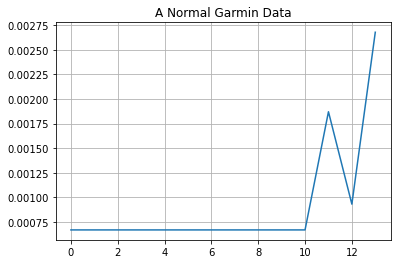

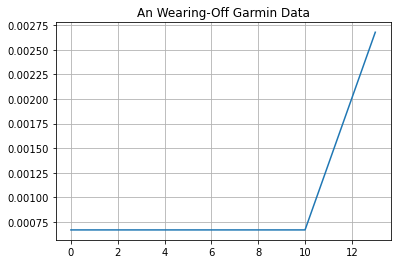

In [83]:
# Plot normal ECG
plt.grid()
plt.plot(np.arange(14), normal_train_data[0])
plt.title("A Normal Garmin Data")
plt.show()


plt.grid()
plt.plot(np.arange(14), anomalous_train_data[0])
plt.title("An Wearing-Off Garmin Data")
plt.show()


## Build model

In [97]:
K.clear_session()
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu", kernel_constraint=MaxNorm(3)),
      layers.Dropout(0.2),
      layers.Dense(16, activation="relu", kernel_constraint=MaxNorm(3)),
      layers.Dropout(0.2),
      layers.Dense(8, activation="relu", kernel_constraint=MaxNorm(3))
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu", kernel_constraint=MaxNorm(3)),
      layers.Dropout(0.2),
      layers.Dense(14, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [98]:
autoencoder.compile(loss='mae',
                    optimizer='adam')

In [100]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=8,
          validation_data=(test_data, test_data),
          callbacks=[early_stopping],
          shuffle=True)

Epoch 1/20
151/151 [==============================] - 1s 4ms/step - loss: 0.2379 - val_loss: 0.0442
Epoch 2/20
151/151 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0308
Epoch 3/20
151/151 [==============================] - 1s 4ms/step - loss: 0.0437 - val_loss: 0.0204
Epoch 4/20
151/151 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0196
Epoch 5/20
151/151 [==============================] - 0s 3ms/step - loss: 0.0281 - val_loss: 0.0169
Epoch 6/20
151/151 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.0174
Epoch 7/20
151/151 [==============================] - 0s 3ms/step - loss: 0.0230 - val_loss: 0.0172


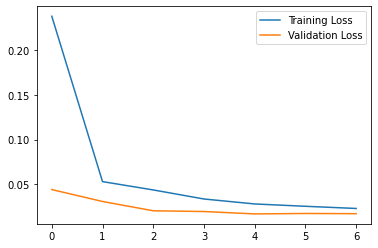

In [101]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

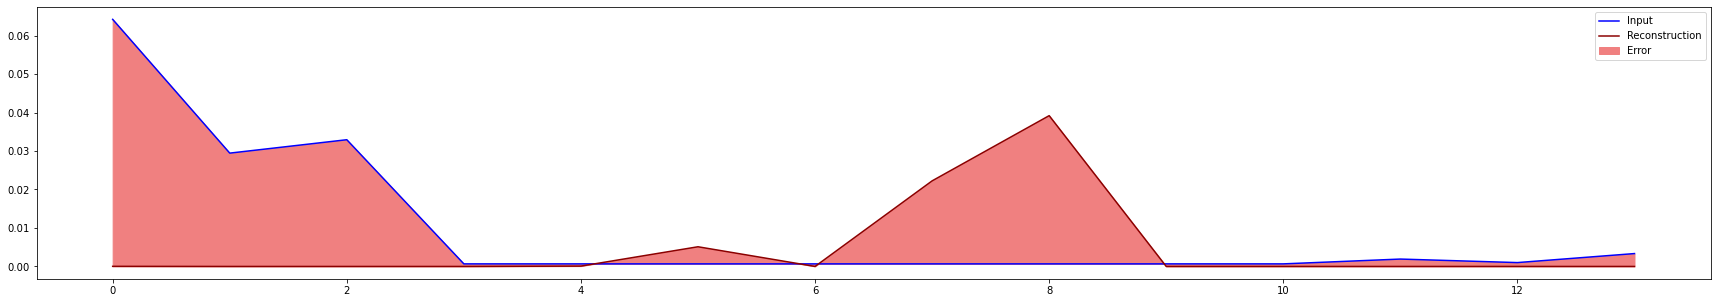

In [102]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(30,5))
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'darkred')
plt.fill_between(np.arange(14), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


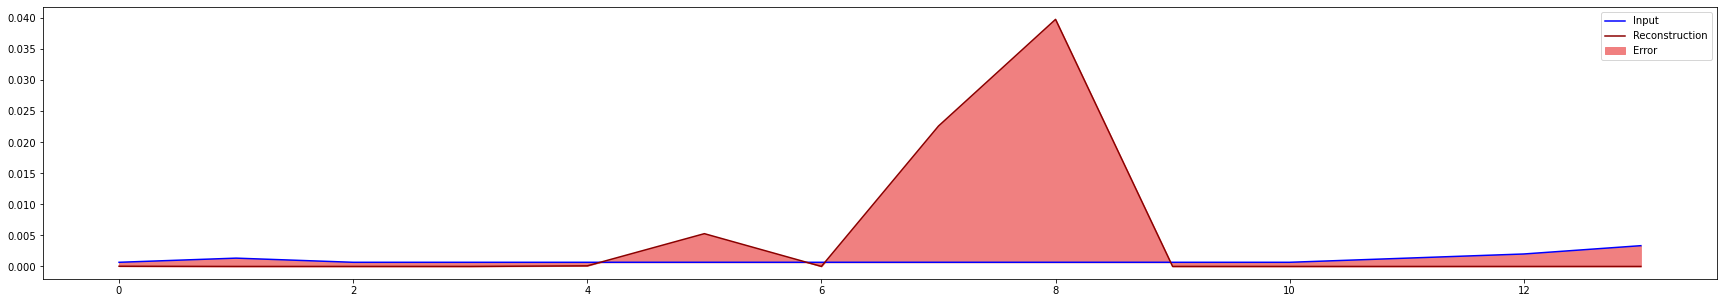

In [103]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(30,5))
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'darkred')
plt.fill_between(np.arange(14), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Detect anomalies

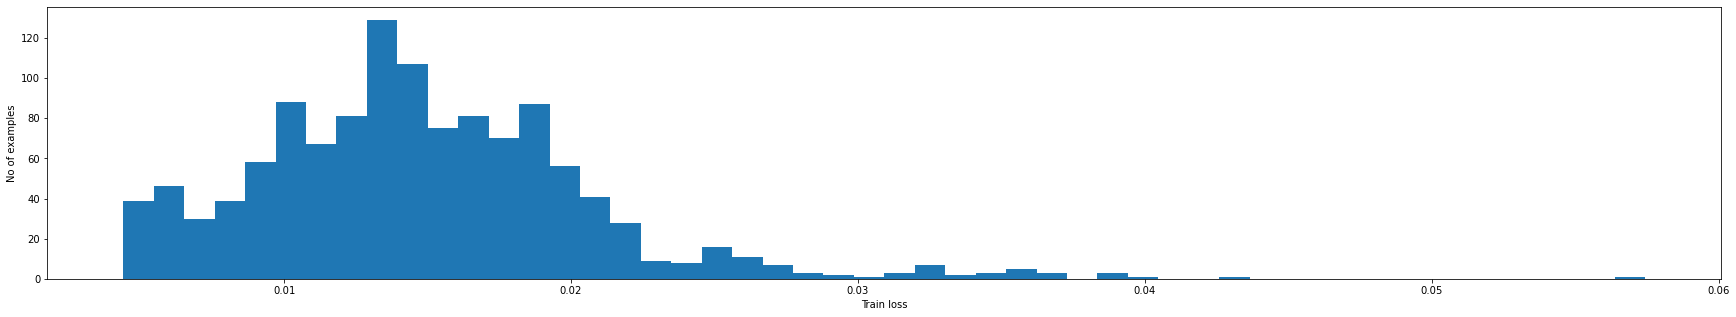

In [104]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.figure(figsize=(30,5))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [105]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.020784616


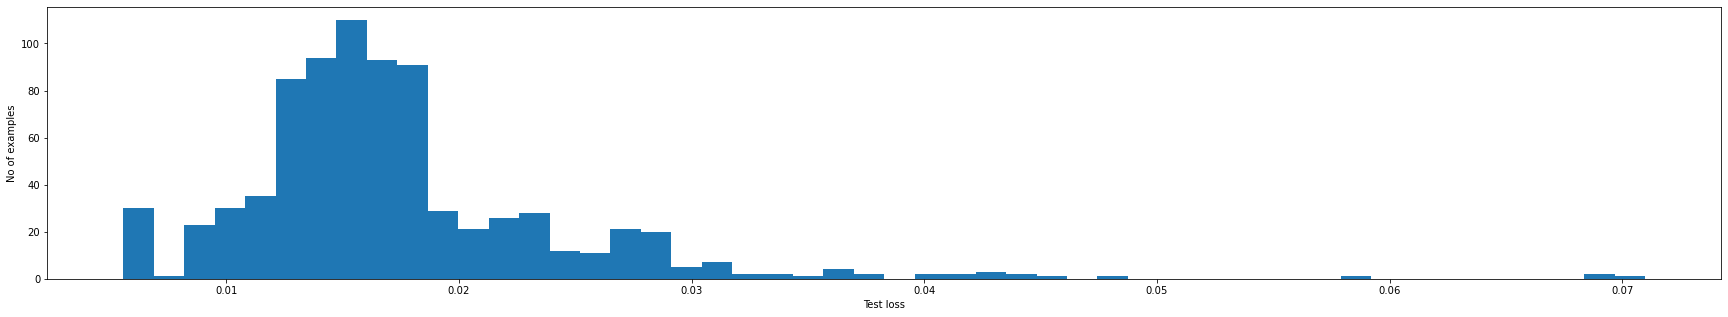

In [106]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.figure(figsize=(30,5))
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [107]:
test_threshold = np.mean(test_loss) + np.std(test_loss)
print("Threshold: ", test_threshold)

Threshold:  0.024612743


In [108]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)


def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  print("F1 = {}".format(f1_score(labels, predictions)))


In [68]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.33912037037037035
Precision = 0.06984667802385008
Recall = 0.6212121212121212
F1 = 0.12557427258805512


In [81]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.2835648148148148
Precision = 0.08042488619119878
Recall = 0.803030303030303
F1 = 0.14620689655172414


In [95]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.21643518518518517
Precision = 0.08207934336525308
Recall = 0.9090909090909091
F1 = 0.15056461731493098


In [109]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.2604166666666667
Precision = 0.085383502170767
Recall = 0.8939393939393939
F1 = 0.15587846763540292
